In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy
from scipy import linalg
import control
import dubins
from dubins import calcDubinsPath,dubins_traj,Waypoint
import math
from numpy import random
random.seed(10)
from scipy.spatial import distance
from scipy import interpolate
from makePD import *

### Generate Dubin's Path

No RLR Path
No LRL Path


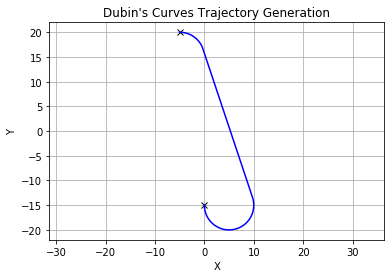

In [2]:
pt1 = Waypoint(0,-15,-180)
pt2 = Waypoint(-5,20,-90)
#pt3 = Waypoint(1000,15000,180)
#pt4 = Waypoint(0,0,270)
Wptz = [pt1, pt2]
# Run the code
i = 0
while i<len(Wptz)-1:
    param = calcDubinsPath(Wptz[i], Wptz[i+1], 5)
    path = dubins_traj(param,10000)
  
    # Plot the results
    plt.plot(Wptz[i].x,Wptz[i].y,'kx')
    plt.plot(Wptz[i+1].x,Wptz[i+1].y,'kx')
    plt.plot(path[:,0],path[:,1],'b-')
    i+=1
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves Trajectory Generation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


### Create the true trajectory

##### First, find the closest points, get the correspoinding heading angle, then interpolate between them to create the true trajectory

In [60]:
def closest_node(node, nodes):
    closest_index = distance.cdist(node, nodes).argmin()
    return closest_index

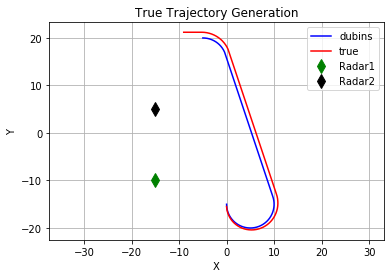

In [61]:
# Start point, 0,-15, and Starting Theta: -90
Xk_1=path[0][0]
yk_1=path[0][1]
ThetaK_1=path[0][2]
n=len(path)
P=path
del_T=0.5
Q=np.zeros((1,2))
samp=124
traj=np.zeros((samp,2))
mean = [0, 0]
cov = [[0.05**2, 0], [0, 0.05**2]]
# s=1+random.multivariate_normal(mean, cov, samp);
s= 1+np.random.normal(0.0, (0.05), size=(10000,1))
idxx=[]
for k in range(samp): 
#     s_k= np.abs(0.05 * np.random.randn(1, 1))
    Xk=Xk_1 +del_T*(s[k])*math.cos((ThetaK_1))
    Yk=yk_1 +del_T*(s[k])*math.sin((ThetaK_1))
    Q[:,0]=Xk
    Q[:,1]=Yk
    traj[k][0]=Xk
    traj[k][1]=Yk
    close_idx=closest_node(Q, P[:,:-1])
    ThetaK_1 = P[close_idx][2]
    idxx.append(close_idx)
#     ThetaK_1=math.atan2( P[close_idx][1]-Yk,P[close_idx][0]-Xk)
  
    Xk_1=Xk
    yk_1=Yk

# interpolate traj to make it 10000 grid points. 
x_spce = np.linspace(0,1,124)
xnew_spc = np.linspace(0,1,10000)
tck_x = interpolate.splrep(x_spce, traj[:,0], s=0)
tck_y = interpolate.splrep(x_spce, traj[:,1], s=0)
x_intrp = interpolate.splev(xnew_spc, tck_x, der=0)
y_intrp = interpolate.splev(xnew_spc, tck_y, der=0)

plt.plot(P[:,0],P[:,1],'b-',label= 'dubins')
plt.plot(x_intrp,y_intrp,'r-',label='true')
plt.plot(-15,-10,'gd',markersize=10,label='Radar1')
plt.plot(-15,5,'kd',markersize=10,label='Radar2')
plt.grid(True)
plt.axis("equal")
plt.title('True Trajectory Generation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

## Radar Set 1
#### Sensor's Measurements

In [90]:
samp=10000
mean = [0, 0, 0]
cov = [[9*(np.pi/180)**2, 0, 0], [0, 9*(np.pi/180)**2, 0], [0, 0, 5*(np.pi/180)**2]]
V1,V2,V3=random.multivariate_normal(mean, cov, samp).T;
# Bearing and Heading measurements
x1=-15
y1=-10
x2=-15
y2=5
y_meas=np.zeros((samp,3));
for k in range(samp):
    Beta1=np.array(math.atan(math.radians((y_intrp[k]-y1)//(x_intrp[k]-x1)))+V1[k])
    Beta2=np.array(math.atan(math.radians((y_intrp[k]-y2)//(x_intrp[k]-x2)))+V2[k])
    Theta_k=np.array(P[k][2]+V3[k])
    y_meas[k,0]=Beta1
    y_meas[k,1]=Beta2
    y_meas[k,2]=Theta_k


In [91]:
dt=0.5
x1=-15
y1=-10
x2=-15
y2=5
num_data=10000
P_k_1=np.array([[0.01, 0, 0],[0, 0.01, 0],[0, 0, 0.01]])
Q= np.array([[0.05**2, 0],[0, 0.04*0.25]])
R=np.array([[9*(np.pi/180)**2, 0, 0],[0, 9*(np.pi/180)**2, 0],[0, 0, 5*(np.pi/180)**2]])
diag=[0.1,0.1,0.1,0.05**2,0.04*0.25,9*(np.pi/180)**2,9*(np.pi/180)**2,5*(np.pi/180)**2]
P_cov=diag*(np.eye(8));
L = 8;
alpha=0.001;
kappa=0;
beta=2
lemda=alpha**2 *(L+kappa)-L
W0_m=lemda/(L+lemda)
W0_c=lemda/(L+lemda) + (1-alpha**2 +beta)
Wi_m=1/(2*(L+lemda))
Wi_c=Wi_m

Xk_1=path[0][0]
yk_1=path[0][1]
ThetaK_1=-180#path[0][2]
state_mean=np.array([Xk_1,yk_1,ThetaK_1,0,0,0,0,0])
state_mean=np.expand_dims(state_mean, axis=0)

In [92]:
def sigma_points(Stmean,P_cov,L,lemda):
    Pnew=(L+lemda)*P_cov
    if np.all(linalg.eigvals(Pnew) > 0)==True:
        
        Ppd=0.5*(Pnew+Pnew.T)
    else:
        Ppd=Pnew
    
        
    Ppd=nearestPD(Ppd) # Ensure positive definite
    #print('Symmetric? ',np.all(linalg.eigvals(Ppd) > 0))
    print('Pos def? ',np.allclose(Ppd, Ppd.T, rtol=1e-05, atol=1e-08))
    Xup=Stmean+linalg.sqrtm(Ppd)
    Xdwn=Stmean-linalg.sqrtm(Ppd)
    sigma_pts=np.concatenate(( Stmean,Xup,Xdwn),axis=1)
    return sigma_pts


In [93]:
def F_nonlinearTX(sgmaPTs,dt,s,i):
    x =sgmaPTs[0,:]+dt*(s[i]+sgmaPTs[3,:])*np.cos((np.pi/180)*(sgmaPTs[2,:]))
    x=np.expand_dims(x,axis=0)
    y=sgmaPTs[1,:]+dt*(s[i]+sgmaPTs[3,:])*np.sin((np.pi/180)*(sgmaPTs[2,:]))
    y=np.expand_dims(y,axis=0)
    theta=sgmaPTs[2,:]+sgmaPTs[4,:]
    theta=np.expand_dims(theta,axis=0)
   
    return np.concatenate(( x,y,theta),axis=0)

In [94]:
def H_nonlinearTX(caliX,sgmaPTs,x1,y1,x2,y2):
    bt1y=((np.pi/180*(caliX[1,:]-y1)))
    bt1x=(np.pi/180*(caliX[0,:]-x1))
    
    bt2y=((np.pi/180*(caliX[1,:]-y2)))
    bt2x=(np.pi/180*(caliX[0,:]-x2))
    
    Beta1=np.arctan(bt1y/bt1x)+sgmaPTs[5,:]
    Beta2=np.arctan(bt2y/bt2x)+sgmaPTs[6,:]
    Theta_k=(np.pi/180)*(caliX[2,:])+sgmaPTs[7,:]
    Beta1=np.expand_dims(Beta1,axis=0)
    Beta2=np.expand_dims(Beta2,axis=0)
    Theta_k=np.expand_dims(Theta_k,axis=0)
    return np.concatenate(( Beta1,Beta2,Theta_k),axis=0)

In [95]:
# def x_hatk(W0_m,Wi_m,Xk):
#     W=np.hstack((W0_m,Wi_m*np.ones((16))))
#     W=np.expand_dims(W,axis=0)
#     X_hat_=W@Xk.T
#     return X_hat_

In [96]:
def comp_x_hat_k_minus(W0_m,Wi_m,caligrap_x):
    x_hat_k_minus = np.zeros((caligrap_x.shape[0],))
    
    for i in range(caligrap_x.shape[-1]):
        if i == 0:
            x_hat_k_minus = W0_m * caligrap_x[:,i]
        else:
            x_hat_k_minus += Wi_m * caligrap_x[:,i]
    return np.expand_dims(x_hat_k_minus,-1)

In [97]:
def comp_P_k_minus(W0_c,Wi_c,caligraph_x,x_hat_k_minus):
    P_k_minus = np.zeros((caligraph_x.shape[0],caligraph_x.shape[0]))
    
    for i in range(caligraph_x.shape[-1]):
        
        if i == 0:
            P_k_minus = W0_c * (caligraph_x[:,i]-x_hat_k_minus) @ (caligraph_x[:,i]-x_hat_k_minus).T
        else:
            P_k_minus += Wi_c * (caligraph_x[:,i]-x_hat_k_minus) @ (caligraph_x[:,i]-x_hat_k_minus).T
    return P_k_minus

In [98]:
def comp_y_hat_k_minus(W0_m,Wi_m,Y):
    y_hat_k_minus = np.zeros((Y.shape[0],))
    
    for i in range(Y.shape[-1]):
        if i == 0:
            y_hat_k_minus = W0_m * Y[:,i]
        else:
            y_hat_k_minus += Wi_m * Y[:,i]
    return np.expand_dims(y_hat_k_minus,-1)

In [99]:
def comp_P_yk_yk(W0_c,Wi_c,Y,y_hat_k_minus):
    P_yk_yk = np.zeros((Y.shape[0],Y.shape[0]))
    
    for i in range(Y.shape[-1]):
        if i == 0:
            P_yk_yk = W0_c * (Y[:,i]-y_hat_k_minus) @ (Y[:,i]-y_hat_k_minus).T
        else:
            P_yk_yk += Wi_c * (Y[:,i]-y_hat_k_minus) @ (Y[:,i]-y_hat_k_minus).T
    return P_yk_yk

In [100]:
def comp_P_xk_yk(W0_c,Wi_c,Y,y_hat_k_minus,caligraph_x,x_hat_k_minus):
    P_xk_yk = np.zeros((Y.shape[0],Y.shape[0]))
    
    for i in range(Y.shape[-1]):
        if i == 0:
            P_xk_yk = W0_c * (caligraph_x[:,i]-x_hat_k_minus) @ (Y[:,i]-y_hat_k_minus).T
        else:
            P_xk_yk += Wi_c * (caligraph_x[:,i]-x_hat_k_minus) @ (Y[:,i]-y_hat_k_minus).T
    return P_xk_yk

In [101]:

update_states=np.zeros((8,num_data))
update_states[:,0]=np.squeeze(state_mean)
for k in range(1,num_data):
    print(k)
    all_sigma_pts2=sigma_points(np.expand_dims(update_states[:,k-1],-1),P_cov,L,lemda)
    print('sigmapt ',all_sigma_pts2.shape)
    caligrapX=(F_nonlinearTX(all_sigma_pts2,dt,s,k))
    x_hat_=comp_x_hat_k_minus(W0_m,Wi_m,caligrapX)
#     Wc=np.hstack((W0_c,Wi_c*np.ones((2))))
#     P_hat_k=(Wc*np.ones((3,3)))*((caligrapX-x_hat_.T)@(caligrapX-x_hat_.T).T)
    P_hat_k=comp_P_k_minus(W0_c,Wi_c,caligrapX,x_hat_)

    Y_caligrap=(H_nonlinearTX(caligrapX,all_sigma_pts2,x1,y1,x2,y2))
#     y_hat_k=Y_caligrap@(np.hstack((W0_m,Wi_m*np.ones((16)))))
#     y_hat_k=np.expand_dims(y_hat_k,axis=0)
    y_hat_k=comp_y_hat_k_minus(W0_m,Wi_m,Y_caligrap)
    
    
    # Measurement update
    Py=comp_P_yk_yk(W0_c,Wi_c,Y_caligrap,y_hat_k)
    #Py=(Wc*np.ones((3,3)))*((Y_caligrap-y_hat_k.T)@(Y_caligrap-y_hat_k.T).T)
    #Pxy=(caligrapX-x_hat_.T)@(Y_caligrap-y_hat_k.T).T
    Pxy=comp_P_xk_yk(W0_c,Wi_c,Y_caligrap,y_hat_k,caligrapX,x_hat_)
    k_gain=Pxy@linalg.inv(Py)
    print('gain ', k_gain.shape)
    rsdl=np.expand_dims(y_meas[k,:],axis=1)-y_hat_k 
  
    print('rsdl ',rsdl.shape)
    X_hat_k=x_hat_+k_gain@rsdl
    print('x_hat_k ',X_hat_k.shape)
    
    Pk=P_hat_k-k_gain*Py*k_gain.T
    
    update_states[0:3,i]=np.squeeze(X_hat_k)
    #print(X_hat_k.T)
    #print(state_mean)
    [a1,b1]=linalg.eig(Pk)
    amin=np.min(a1)
    Pk_2=b1@(a1+(amin+0.001)*np.eye(3))@linalg.inv(b1)
    P_cov[0:3,0:3]=Pk_2


    
   

    

1
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
10
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
11
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
12
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
13
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
14
Pos d

C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Home\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


 (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
43
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
44
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
45
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
46
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
47
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
48
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
49
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
50
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
51
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
52
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
53
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
54
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
55
Pos def?  True
sigmapt  (8, 17)
gain

195
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
196
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
197
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
198
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
199
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
200
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
201
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
202
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
203
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
204
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
205
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
206
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
207
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_

x_hat_k  (3, 1)
358
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
359
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
360
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
361
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
362
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
363
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
364
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
365
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
366
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
367
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
368
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
369
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
370
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
464
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
465
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
466
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
467
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
468
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
469
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
470
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
471
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
472
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
473
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
474
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
475
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
476
P

x_hat_k  (3, 1)
621
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
622
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
623
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
624
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
625
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
626
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
627
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
628
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
629
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
630
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
631
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
632
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
633
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
778
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
779
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
780
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
781
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
782
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
783
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
784
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
785
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
786
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
787
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
788
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
789
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
887
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
888
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
889
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
890
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
891
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
892
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
893
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
894
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
895
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
896
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
897
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
898
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1043
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1044
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1045
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1046
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1047
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1048
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1049
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1050
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1051
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1052
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1053
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1054
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

x_hat_k  (3, 1)
1195
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1196
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1197
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1198
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1199
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1200
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1201
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1202
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1203
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1204
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1205
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1206
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1207
Pos def?  True
sigmapt  (8, 17)

rsdl  (3, 1)
x_hat_k  (3, 1)
1305
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1306
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1307
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1308
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1309
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1310
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1311
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1312
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1313
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1314
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1315
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1316
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1317
Pos def?  True
sig

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1413
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1414
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1415
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1416
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1417
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1418
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1419
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1420
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1421
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1422
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1423
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1424
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1523
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1524
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1525
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1526
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1527
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1528
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1529
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1530
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1531
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1532
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1533
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1534
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1535
Pos d

rsdl  (3, 1)
x_hat_k  (3, 1)
1675
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1676
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1677
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1678
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1679
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1680
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1681
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1682
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1683
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1684
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1685
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1686
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1687
Pos def?  True
sig

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1780
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1781
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1782
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1783
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1784
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1785
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1786
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1787
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1788
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1789
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1790
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1791
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1886
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1887
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1888
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1889
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1890
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1891
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1892
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1893
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1894
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1895
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1896
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1897
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1990
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1991
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1992
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1993
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1994
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1995
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1996
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1997
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1998
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
1999
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2000
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2001
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2096
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2097
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2098
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2099
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2100
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2101
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2102
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2103
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2104
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2105
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2106
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2107
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

2250
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2251
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2252
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2253
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2254
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2255
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2256
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2257
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2258
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2259
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2260
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2261
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2262
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

x_hat_k  (3, 1)
2358
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2359
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2360
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2361
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2362
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2363
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2364
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2365
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2366
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2367
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2368
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2369
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2370
Pos def?  True
sigmapt  (8, 17)

rsdl  (3, 1)
x_hat_k  (3, 1)
2468
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2469
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2470
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2471
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2472
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2473
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2474
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2475
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2476
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2477
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2478
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2479
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2480
Pos def?  True
sig

rsdl  (3, 1)
x_hat_k  (3, 1)
2617
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2618
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2619
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2620
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2621
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2622
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2623
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2624
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2625
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2626
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2627
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2628
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2629
Pos def?  True
sig

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2728
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2729
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2730
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2731
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2732
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2733
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2734
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2735
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2736
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2737
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2738
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2739
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

rsdl  (3, 1)
x_hat_k  (3, 1)
2834
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2835
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2836
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2837
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2838
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2839
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2840
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2841
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2842
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2843
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2844
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2845
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2846
Pos def?  True
sig

rsdl  (3, 1)
x_hat_k  (3, 1)
2986
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2987
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2988
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2989
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2990
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2991
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2992
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2993
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2994
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2995
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2996
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2997
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
2998
Pos def?  True
sig

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3090
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3091
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3092
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3093
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3094
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3095
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3096
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3097
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3098
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3099
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3100
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3101
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3197
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3198
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3199
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3200
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3201
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3202
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3203
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3204
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3205
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3206
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3207
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3208
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3209
Pos d

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3345
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3346
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3347
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3348
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3349
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3350
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3351
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3352
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3353
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3354
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3355
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3356
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3357
Pos d

rsdl  (3, 1)
x_hat_k  (3, 1)
3495
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3496
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3497
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3498
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3499
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3500
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3501
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3502
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3503
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3504
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3505
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3506
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3507
Pos def?  True
sig

3648
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3649
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3650
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3651
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3652
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3653
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3654
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3655
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3656
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3657
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3658
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3659
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3660
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3759
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3760
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3761
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3762
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3763
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3764
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3765
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3766
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3767
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3768
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3769
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3770
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3864
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3865
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3866
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3867
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3868
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3869
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3870
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3871
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3872
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3873
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3874
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
3875
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4007
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4008
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4009
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4010
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4011
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4012
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4013
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4014
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4015
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4016
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4017
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4018
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4019
Pos d

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4112
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4113
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4114
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4115
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4116
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4117
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4118
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4119
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4120
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4121
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4122
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4123
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4268
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4269
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4270
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4271
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4272
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4273
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4274
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4275
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4276
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4277
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4278
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4279
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

rsdl  (3, 1)
x_hat_k  (3, 1)
4419
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4420
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4421
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4422
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4423
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4424
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4425
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4426
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4427
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4428
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4429
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4430
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4431
Pos def?  True
sig

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4573
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4574
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4575
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4576
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4577
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4578
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4579
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4580
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4581
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4582
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4583
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4584
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4723
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4724
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4725
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4726
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4727
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4728
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4729
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4730
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4731
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4732
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4733
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4734
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4873
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4874
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4875
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4876
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4877
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4878
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4879
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4880
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4881
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4882
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4883
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
4884
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

5029
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5030
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5031
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5032
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5033
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5034
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5035
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5036
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5037
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5038
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5039
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5040
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5041
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5183
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5184
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5185
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5186
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5187
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5188
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5189
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5190
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5191
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5192
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5193
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5194
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5340
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5341
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5342
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5343
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5344
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5345
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5346
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5347
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5348
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5349
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5350
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5351
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5352
Pos d

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5494
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5495
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5496
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5497
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5498
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5499
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5500
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5501
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5502
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5503
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5504
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5505
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

5598
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5599
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5600
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5601
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5602
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5603
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5604
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5605
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5606
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5607
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5608
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5609
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5610
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5749
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5750
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5751
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5752
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5753
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5754
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5755
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5756
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5757
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5758
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5759
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5760
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

rsdl  (3, 1)
x_hat_k  (3, 1)
5898
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5899
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5900
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5901
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5902
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5903
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5904
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5905
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5906
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5907
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5908
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5909
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
5910
Pos def?  True
sig

x_hat_k  (3, 1)
6045
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6046
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6047
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6048
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6049
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6050
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6051
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6052
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6053
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6054
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6055
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6056
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6057
Pos def?  True
sigmapt  (8, 17)

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6191
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6192
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6193
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6194
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6195
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6196
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6197
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6198
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6199
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6200
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6201
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6202
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6203
Pos d

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6341
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6342
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6343
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6344
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6345
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6346
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6347
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6348
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6349
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6350
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6351
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6352
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6497
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6498
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6499
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6500
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6501
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6502
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6503
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6504
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6505
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6506
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6507
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6508
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

6648
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6649
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6650
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6651
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6652
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6653
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6654
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6655
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6656
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6657
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6658
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6659
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6660
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6805
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6806
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6807
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6808
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6809
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6810
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6811
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6812
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6813
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6814
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6815
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6816
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6817
Pos d

x_hat_k  (3, 1)
6917
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6918
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6919
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6920
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6921
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6922
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6923
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6924
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6925
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6926
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6927
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6928
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
6929
Pos def?  True
sigmapt  (8, 17)

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7067
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7068
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7069
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7070
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7071
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7072
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7073
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7074
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7075
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7076
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7077
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7078
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

7216
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7217
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7218
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7219
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7220
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7221
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7222
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7223
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7224
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7225
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7226
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7227
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7228
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7321
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7322
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7323
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7324
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7325
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7326
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7327
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7328
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7329
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7330
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7331
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7332
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

rsdl  (3, 1)
x_hat_k  (3, 1)
7477
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7478
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7479
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7480
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7481
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7482
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7483
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7484
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7485
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7486
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7487
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7488
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7489
Pos def?  True
sig

x_hat_k  (3, 1)
7627
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7628
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7629
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7630
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7631
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7632
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7633
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7634
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7635
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7636
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7637
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7638
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7639
Pos def?  True
sigmapt  (8, 17)

7782
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7783
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7784
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7785
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7786
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7787
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7788
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7789
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7790
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7791
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7792
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7793
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7794
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

rsdl  (3, 1)
x_hat_k  (3, 1)
7935
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7936
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7937
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7938
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7939
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7940
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7941
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7942
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7943
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7944
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7945
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7946
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
7947
Pos def?  True
sig

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8042
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8043
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8044
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8045
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8046
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8047
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8048
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8049
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8050
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8051
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8052
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8053
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8199
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8200
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8201
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8202
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8203
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8204
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8205
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8206
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8207
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8208
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8209
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8210
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8308
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8309
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8310
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8311
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8312
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8313
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8314
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8315
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8316
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8317
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8318
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8319
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8459
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8460
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8461
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8462
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8463
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8464
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8465
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8466
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8467
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8468
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8469
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8470
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

rsdl  (3, 1)
x_hat_k  (3, 1)
8605
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8606
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8607
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8608
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8609
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8610
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8611
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8612
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8613
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8614
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8615
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8616
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8617
Pos def?  True
sig

8754
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8755
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8756
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8757
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8758
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8759
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8760
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8761
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8762
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8763
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8764
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8765
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8766
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rs

rsdl  (3, 1)
x_hat_k  (3, 1)
8902
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8903
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8904
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8905
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8906
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8907
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8908
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8909
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8910
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8911
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8912
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8913
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
8914
Pos def?  True
sig

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9008
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9009
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9010
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9011
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9012
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9013
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9014
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9015
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9016
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9017
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9018
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9019
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9113
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9114
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9115
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9116
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9117
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9118
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9119
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9120
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9121
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9122
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9123
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9124
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9265
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9266
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9267
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9268
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9269
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9270
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9271
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9272
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9273
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9274
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9275
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9276
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9277
Pos d

sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9415
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9416
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9417
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9418
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9419
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9420
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9421
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9422
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9423
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9424
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9425
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9426
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  

gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9564
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9565
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9566
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9567
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9568
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9569
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9570
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9571
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9572
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9573
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9574
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9575
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9576
Pos d

rsdl  (3, 1)
x_hat_k  (3, 1)
9668
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9669
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9670
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9671
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9672
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9673
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9674
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9675
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9676
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9677
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9678
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9679
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9680
Pos def?  True
sig

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9818
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9819
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9820
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9821
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9822
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9823
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9824
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9825
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9826
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9827
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9828
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9829
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9974
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9975
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9976
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9977
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9978
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9979
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9980
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9981
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9982
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9983
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9984
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (3, 1)
x_hat_k  (3, 1)
9985
Pos def?  True
sigmapt  (8, 17)
gain  (3, 3)
rsdl  (

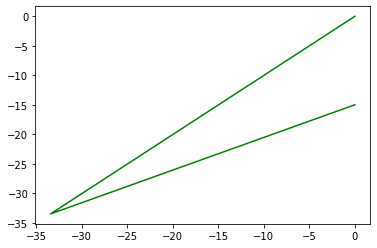

In [104]:
plt.plot(update_states[0,:],update_states[1,:],'g-',label='EKF')